In [12]:
# DataFrame
import pandas as pd


# Matplot
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.express as px

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

#Previous Sentiment Libraries
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [13]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Michael\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
df = pd.read_csv('Tweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

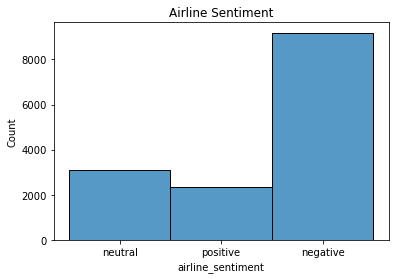

In [19]:
#Create histogram
sns.histplot(data=df, x='airline_sentiment')
plt.title('Airline Sentiment')
plt.show()

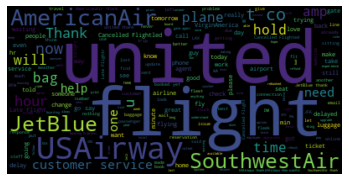

In [20]:
#Create stopword list
stopwords = set(STOPWORDS)
#stopwords = stopwords.words('english')
stopwords.update(['br', 'href'])
textt = ''.join(review for review in df.text)
wordcloud = WordCloud(stopwords=stopwords).generate(textt)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [21]:
#split df - positive, negative, and neutral sentiment
positive = df[df['airline_sentiment'] == 'positive']
negative = df[df['airline_sentiment'] == 'negative']
neutral = df[df['airline_sentiment'] == 'neutral']

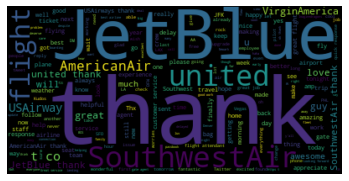

In [23]:
#positive wordcloud
stopwords = set(STOPWORDS)
stopwords.update(["br", "href"])
pos = ''.join(review for review in positive.text)
wordcloud2 = WordCloud(stopwords=stopwords).generate(pos)
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis('off')
plt.show()

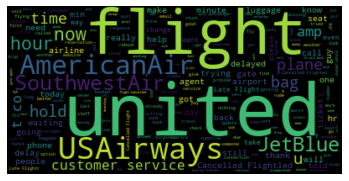

In [24]:
#negative wordcloud
stopwords = set(STOPWORDS)
stopwords.update(["br", "href"])
neg = ''.join(review for review in negative.text)
wordcloud2 = WordCloud(stopwords=stopwords).generate(neg)
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis('off')
plt.show()

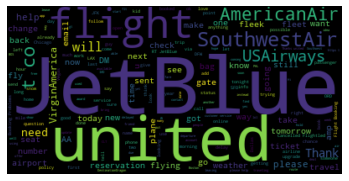

In [25]:
#neutral wordcloud
stopwords = set(STOPWORDS)
stopwords.update(["br", "href"])
neu = ''.join(review for review in neutral.text)
wordcloud2 = WordCloud(stopwords=stopwords).generate(neu)
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis('off')
plt.show()

In [26]:
#Data cleaning
def remove_punctuation(text):
    final = ''.join(u for u in text if u not in ('?', '.', ';', ':', '!', '"', ','))
    return final
df['text'] = df['text'].apply(remove_punctuation)
df = df.dropna(subset=['text'])

In [30]:
dfNew = df[['text', 'airline_sentiment']]
dfNew.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today Must mean I need...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [31]:
index =df.index
df['random_number'] = np.random.randn(len(index))
train = df[df['random_number'] <= 0.8]
test = df[df['random_number'] > 0.8]

In [33]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')

train_matrix = vectorizer.fit_transform(train['text'].values.astype('U'))
test_matrix = vectorizer.transform(test['text'].values.astype('U'))

In [34]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

In [35]:
#Split target and independent variables
x_train = train_matrix
x_test = test_matrix
y_train = train['airline_sentiment']
y_test = test['airline_sentiment']

In [36]:
#Fit model on data
lr.fit(x_train, y_train)

C:\Users\Michael\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression()

In [37]:
#Make predictions
predictions = lr.predict(x_test)

In [38]:
# find accuracy, precision, recall
from sklearn.metrics import confusion_matrix,classification_report
new = np.asarray(y_test)
confusion_matrix(predictions,y_test)

array([[1734,  198,   88],
       [ 148,  395,   78],
       [  44,   61,  356]], dtype=int64)

In [39]:
print(classification_report(predictions,y_test))

              precision    recall  f1-score   support

    negative       0.90      0.86      0.88      2020
     neutral       0.60      0.64      0.62       621
    positive       0.68      0.77      0.72       461

    accuracy                           0.80      3102
   macro avg       0.73      0.76      0.74      3102
weighted avg       0.81      0.80      0.80      3102

